In [1]:
# --- Import Libraries
import copy
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, losses, optimizers
from sklearn import random_projection
from sklearn.metrics import accuracy_score

from op import *
from utils import *
from custom import *
from metrics import *
from trainer import *
from data import Dataset

**Notes:** 

**Deeper better than wider!**
**|**
**Nonlinear > Linear!**
**|**
**Small batch size is better!**
* https://link.springer.com/article/10.1007/s10044-018-0697-0
* https://keras.io/examples/vision/grad_cam/

In [2]:
#--- Autoselect GPU
from jarvis.utils.general import gpus
gpus.autoselect()

[ 2021-04-28 20:35:52 ] CUDA_VISIBLE_DEVICES automatically set to: 1           


In [3]:
# TODO check if binary or dual output then argmax if double else 0.5 thresh

In [4]:
# --- Model Blocks
conv = lambda x, features, dr=1, name=None : layers.Conv1D(filters=features, kernel_size=1, strides=1, dilation_rate=dr, padding='same', name=name)(x)
elu  = lambda x: layers.ELU()(x)
norm = lambda x: layers.BatchNormalization()(x)
mlp  = lambda x, features, dr=1: elu(norm((conv(x, features, dr))))

# --- Model Architecture
def encoder(x, features):
    for f in features:
        x = mlp(x, f)
    return x

def decoder(x, features):
    features = features[::-1]
    for f in features:
        x = mlp(x, f)
    return x

def network(dataset):
    tf.random.set_seed(0)
    x = dataset.Input
    input_size = x.shape[-1]
    features = [512, 256, 128]
    embed_size = 32
    outputs = {}
    
    x_ = encoder(x, features)
    embedding = mlp(x_, embed_size)
    x_ = decoder(embedding, features)

    name_me = layers.Lambda(lambda x: x, name=dataset.l2)
    classification = conv(embedding, 1, name=dataset.l1)
    reconstruction = layers.ReLU()(conv(x_, input_size))
    reconstruction = name_me(reconstruction)
#     reconstruction = conv(x_, input_size, name=dataset.l2)
    
    outputs[dataset.l1] = classification
    outputs[dataset.l2] = reconstruction
    
    return Model(x, outputs)
        
# --- Model Compile
def compile_(model, dataset, lr=1e-2):
    tf.random.set_seed(0)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr), 
#         loss={dataset.l1: losses.SparseCategoricalCrossentropy(from_logits=True),
        loss={dataset.l1: BCE(),
              dataset.l2: WMSE()}, 
        metrics={dataset.l1: ['accuracy', tf.keras.metrics.AUC()],
                 dataset.l2: 'mean_absolute_error'},
        experimental_run_tf_function=False)

    return model

# --- Model Trainer
def train(model, dataset):
    tf.random.set_seed(0)
    outputs = {}
    outputs[dataset.l1] = dataset.ytr
    outputs[dataset.l2] = dataset.xtr
    class_weights = {dataset.l1: dataset.weights}
    
    validation = {}
    validation[dataset.l1] = dataset.yte
    validation[dataset.l2] = dataset.xte
    
    history = model.fit(
        x=dataset.xtr,
        y=outputs, 
        batch_size=64, 
        epochs=10,
#         validation_data=(dataset.xte, validation), 
#         validation_freq=4,
        class_weight=class_weights,
#         verbose=0,
    )
    return history

In [5]:
def summarize(history, model, dataset):
    print('=========TRAIN=========')
#     print('acc: {}'.format(history.history['classification_accuracy'][-1]))
#     print('reconstruction error: {}'.format(history.history['reconstruction_mean_absolute_error'][-1]))
    evaluate(model, dataset.xtr, dataset.ytr)
    print('=========VALID=========')
#     print('acc: {}'.format(history.history['val_classification_accuracy'][-1]))
#     print('reconstruction error: {}'.format(history.history['val_reconstruction_mean_absolute_error'][-1]))
    evaluate(model, dataset.xte, dataset.yte)
    
def evaluate(model, data, labels):
    # test on whole dataset
    preds = model.predict(data)

    if type(preds) == list: preds = preds[0];
    if preds.shape[-1] == 1: preds = 1*(preds.squeeze() > 0.5)
    else: preds = np.argmax(preds, axis=-1);
        
    print(preds.shape)
    
    print('baseline acc: {}'.format(class_one_acc(labels)))
    print('model pred acc: {}'.format(acc(labels, preds)))
    
def default_dataset():
    path = 'data/ctrl_vs_case.csv'
    dataset = Dataset(path, train_size=0.7)
    dataset.feature_selection(mode='s')
    return dataset

In [6]:
def run_pipeline(dataset, mode):
    # --- Feature Selection
    dataset.feature_selection(norm=False, percentile=10, mode=mode)
    print(dataset.features_.shape)
    print(dataset.features.shape)
    
    # --- Prepare Model
    tf.random.set_seed(0)
    model = network(dataset)
    model = compile_(model, dataset)
    
    # --- Train Model
    history = train(model, dataset)
    
    # --- Summarize Results
    print()
    print('Training using {} feature selection'.format(mode))
    summarize(history, model, dataset)
    print()
    
    return model, history

In [7]:
# --- Prepare Data
if 'dataset' not in globals():
    path = 'data/ctrl_vs_case.csv'
    dataset = Dataset(path, train_size=0.7)

In [8]:
# --- Train Models
# modes = ['no', 'chi', 'mutual_info']
modes = ['no']
for mode in modes:
    model, history = run_pipeline(dataset, mode)

Using no feature selection and data normalization = False
(163, 1, 53859)
(163, 1, 53859)
Train on 114 samples
Epoch 1/10
114/114 [==============================] - 4s 39ms/sample - loss: 1.5137 - classification_loss: 0.9016 - reconstruction_loss: 0.6238 - classification_accuracy: 0.4203 - classification_auc: 0.1664 - reconstruction_mean_absolute_error: 524.8888
Epoch 2/10
114/114 [==============================] - 0s 2ms/sample - loss: 1.4401 - classification_loss: 0.8036 - reconstruction_loss: 0.6224 - classification_accuracy: 0.5000 - classification_auc: 0.1859 - reconstruction_mean_absolute_error: 524.8886
Epoch 3/10
114/114 [==============================] - 0s 2ms/sample - loss: 1.1996 - classification_loss: 0.5689 - reconstruction_loss: 0.6286 - classification_accuracy: 0.5264 - classification_auc: 0.2138 - reconstruction_mean_absolute_error: 524.8886
Epoch 4/10
114/114 [==============================] - 0s 2ms/sample - loss: 1.1678 - classification_loss: 0.5393 - reconstruction

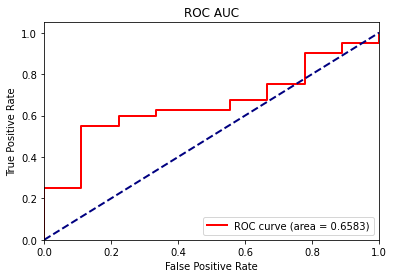

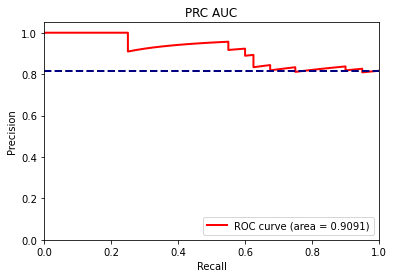

0.9091228540126458

In [9]:
conf_scores = model.predict(dataset.xte)[0].squeeze()

plot_auc(dataset.yte, conf_scores, mode='roc', lw=2)
plot_auc(dataset.yte, conf_scores, mode='prc', lw=2)

In [10]:
model.predict(dataset.xtr)[1].squeeze()[0, :10]

array([0.42481428, 0.        , 0.        , 0.71824443, 0.        ,
       0.5745534 , 0.        , 0.3383579 , 0.        , 0.24111415],
      dtype=float32)

In [11]:
dataset.xtr.squeeze()[0, :10]

array([  0.        , 142.96032891,  29.81994591,   6.13940063,
         0.        ,   0.        ,   0.        ,   7.01645786,
         0.87705723,   6.13940063])

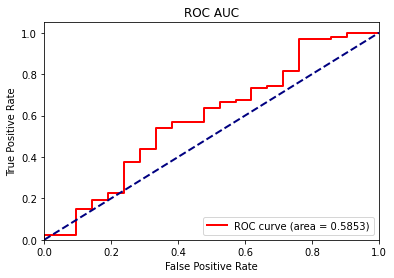

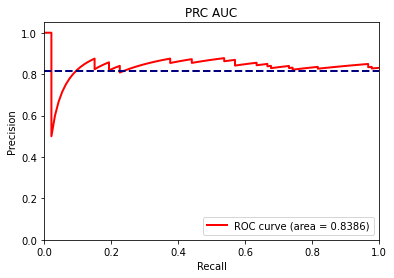

0.838557526623069

In [12]:
conf_scores = model.predict(dataset.xtr)[0].squeeze()

plot_auc(dataset.ytr, conf_scores, mode='roc', lw=2)
plot_auc(dataset.ytr, conf_scores, mode='prc', lw=2)

# Machine Learning Stuff...

In [14]:
# dataset = default_dataset()
Xtr, Xte, Ytr, Yte = [np.array(data.squeeze()) for data in [dataset.xtr, dataset.xte, dataset.ytr, dataset.yte]]

In [15]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


def pca(x, n=100, verbose=False):
    model = PCA(n).fit(x)
    if verbose:
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.xlabel('n components')
        plt.ylabel('cumulative variance');
    return model


def hard_predict(model, x):
    return model.predict(x)


def soft_predict(model, x):
    return model.predict_proba(x)[:, 1]


def plot_curves(model, x, y):
    pred = hard_predict(model, x)
    conf_scores = soft_predict(model, x)
    plot_auc(y, conf_scores, mode='roc', lw=2)
    plot_auc(y, conf_scores, mode='prc', lw=2)
    
    
def results(model, xtr, ytr, xte, yte):
    print('==================')
    print('baseline train acc: {}'.format(class_one_acc(ytr)))
    print('baseline test acc : {}'.format(class_one_acc(yte)))
    print()
    hptr = hard_predict(model, xtr)
    hpte = hard_predict(model, xte)
    print('model train acc: {}'.format(acc(ytr, hptr)))
    print('model test acc: {}'.format(acc(yte, hpte)))
    print()
    sptr = soft_predict(model, xtr)
    spte = soft_predict(model, xte)
    print('model train auc: {}'.format(roc_auc(ytr, sptr)))
    print('model test auc: {}'.format(roc_auc(yte, spte)))
    print('==================')
    
    print('Test-set')
    plot_curves(model, xte, yte)
    

def knn(xtr, ytr, xte, yte, n=3):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)
    
    
def rf(xtr, ytr, xte, yte, n=1):
    model = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0, class_weight='balanced')
    model.fit(xtr, ytr)
    
    results(model, xtr, ytr, xte, yte)

(114, 5386) (114, 100)
- KNN
baseline train acc: 0.8157894736842105
baseline test acc : 0.8163265306122449

model train acc: 0.8421052631578947
model test acc: 0.7755102040816326

model train auc: 0.8709677419354838
model test auc: 0.32777777777777783
Test-set


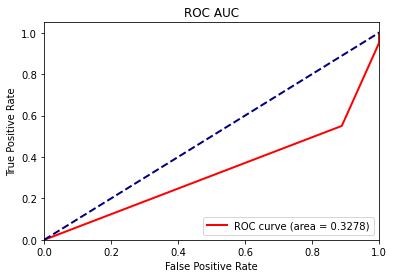

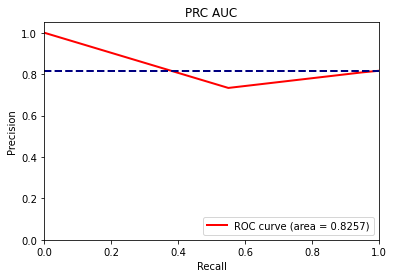

- PCA
baseline train acc: 0.8157894736842105
baseline test acc : 0.8163265306122449

model train acc: 0.8421052631578947
model test acc: 0.7755102040816326

model train auc: 0.8709677419354838
model test auc: 0.32777777777777783
Test-set


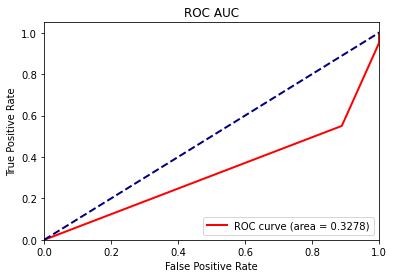

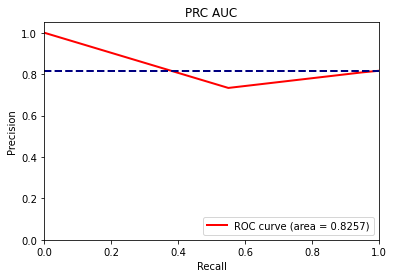


- RF
baseline train acc: 0.8157894736842105
baseline test acc : 0.8163265306122449

model train acc: 0.9912280701754386
model test acc: 0.7959183673469388

model train auc: 0.9989759344598055
model test auc: 0.4833333333333334
Test-set


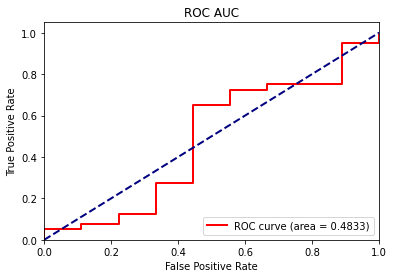

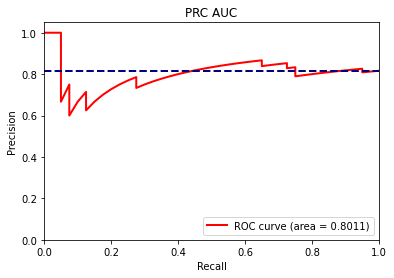

- PCA
baseline train acc: 0.8157894736842105
baseline test acc : 0.8163265306122449

model train acc: 1.0
model test acc: 0.7959183673469388

model train auc: 1.0
model test auc: 0.46111111111111114
Test-set


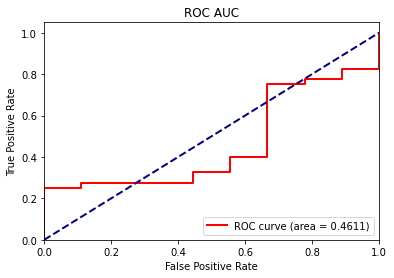

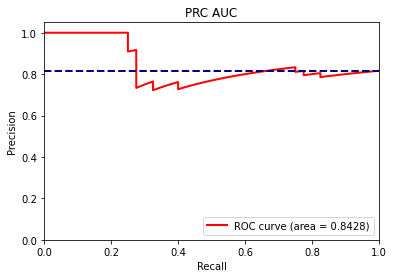

In [16]:
# pca
pc = pca(Xtr)
xtr = pc.transform(Xtr)
xte = pc.transform(Xte)
print(Xtr.shape, xtr.shape)

print('- KNN')
knn(Xtr, Ytr, Xte, Yte)
print('- PCA')
knn(xtr, Ytr, xte, Yte)
print()
print('- RF')
rf(Xtr, Ytr, Xte, Yte)
print('- PCA')
rf(xtr, Ytr, xte, Yte)

0.9570437675996848

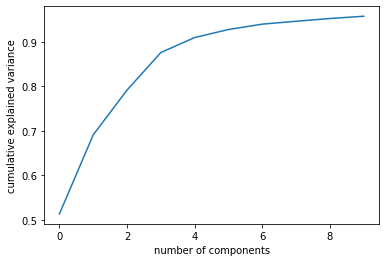

In [11]:
# TODO: check representational power of PCA features

dataset.pca(n_components=10, verbose=True)
np.sum(dataset.pca_.explained_variance_ratio_)

In [12]:
pca_importance(dataset)

,pc,feature
0,pc-1,X7SK.4
1,pc-2,MT.RNR2
2,pc-3,MALAT1
3,pc-4,RN7SL2
4,pc-5,NEFL
5,pc-6,COL3A1
6,pc-7,MAP1B
7,pc-8,COL3A1
8,pc-9,EEF2
9,pc-10,SNORD3C
